# Implementation

Beispielimplementation FER mithilfe eines CNN
Basierend auf https://github.com/gitshanks/fer2013

In [2]:
import sys, os
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Daten laden

In diesem Abschnitt werden die Daten und Labels des FER2013 Datensatz aus einer .csv Datei geladen und vorverarbeitet.

In [4]:
data = pd.read_csv('data/fer2013.csv')

In [5]:
width, height = 48, 48

datapoints = data['pixels'].tolist()

#getting features for training
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

#getting labels for training
y = pd.get_dummies(data['emotion']).values

#data normalization
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

print("Preprocessing Done")
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: "+ str(len(y[0])))
print("Number of examples in dataset:"+str(len(X)))

Preprocessing Done
Number of Features: 48
Number of Labels: 7
Number of examples in dataset:35887


### Daten aufteilen

Hier werden die Daten in Train, Test und Validierungsdaten aufgeteilt und die Testdaten für später gespeichert.

In [6]:
#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

#saving the test samples to be used later
np.save('modXtest', X_test)
np.save('modytest', y_test)

### Modell definieren

<img src="../images/ownModel.jpg">

In [7]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

In [8]:
#desinging the CNN
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

#model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



### Modell trainieren

In [9]:
#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [10]:
#training the model
model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)


Train on 29068 samples, validate on 3230 samples
Epoch 1/100
29068/29068 [==============================] - 17s 573us/step - loss: 1.9859 - accuracy: 0.2133 - val_loss: 1.8271 - val_accuracy: 0.2594
Epoch 2/100
29068/29068 [==============================] - 15s 499us/step - loss: 1.8312 - accuracy: 0.2459 - val_loss: 1.8081 - val_accuracy: 0.2616
Epoch 3/100
29068/29068 [==============================] - 15s 503us/step - loss: 1.7654 - accuracy: 0.2820 - val_loss: 1.7208 - val_accuracy: 0.3022
Epoch 4/100
29068/29068 [==============================] - 15s 533us/step - loss: 1.6388 - accuracy: 0.3501 - val_loss: 1.5385 - val_accuracy: 0.4025
Epoch 5/100
29068/29068 [==============================] - 16s 535us/step - loss: 1.5315 - accuracy: 0.4069 - val_loss: 1.4257 - val_accuracy: 0.4384
Epoch 6/100
29068/29068 [==============================] - 15s 514us/step - loss: 1.4654 - accuracy: 0.4344 - val_loss: 1.3449 - val_accuracy: 0.4789
Epoch 7/100
29068/29068 [=========================

In [11]:
#saving the  model to be used later
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")
print("Saved model to disk")

Saved model to disk


### Trainiertes Modell laden

In diesem Abschnitt wird das traniierte Modell geladen und die zu Beginn definierten Testdaten werden zu Performancemessung verwendet.

In [3]:
json_file = open('fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into model
loaded_model.load_weights("fer.h5")
print("Loaded model from disk")

Loaded model from disk


In [4]:
truey=[]
predy=[]
x = np.load('./modXtest.npy')
y = np.load('./modytest.npy')

yhat= loaded_model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100
print(acc)

65.08776818055169


### Convolution Matrix plotten

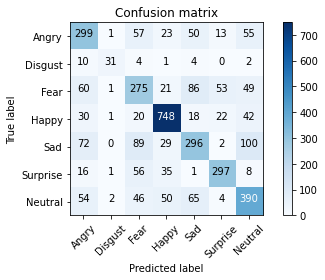

In [39]:
cm = confusion_matrix(truey, predy)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
title='Confusion matrix'

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()